In [1]:
# V : Test de securité des differents modèles et differentes approches


In [2]:
# Importing the library

# V - 1 : Importing of the librairy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from datetime import datetime
from keras.models import Sequential, Model,load_model
from keras.layers import Dropout,Dense
from keras import Input,layers
from keras.layers import LSTM, GRU,Bidirectional
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,make_scorer
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,StackingRegressor,VotingRegressor,GradientBoostingRegressor
from joblib import dump, load
import seaborn as sns

In [3]:
#  V - 2 : Importing the training set
dataset=pd.read_csv("https://raw.githubusercontent.com/oreilly-mlsec/book-resources/599669c7124dffb65ea7f6e0b7626df32496b1d6/chapter3/datasets/cpu-utilization/cpu-full-b.csv", sep=",")


In [4]:
# V - 3 : split of data Test & Training

# Size the data Test, Training
train_size=int(len(dataset)*.85)
test_size=int(len(dataset)*.15)
x_trainning,x_testing=dataset.iloc[0:train_size],dataset.iloc[(train_size+1):(train_size+test_size)]

In [5]:
# V - 4 : Preparing data for timesteps (lags)

def normalisationPreparationDonnee(data,lags):
    data=data['cpu'].values
    sc = MinMaxScaler(feature_range = (0, 1))
    #sc=StandardScaler()
    data1= data.reshape(-1,1)
    data2 = sc.fit_transform(data1)
    def preparation_data():
        x_train = []
        y_train = []
        for i in range(lags,len(data2)):
            x_train.append(data2[i-lags:i, 0])
            y_train.append(data2[i, 0])
        return np.array(x_train), np.array(y_train)
    x_train, y_train = preparation_data()
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train


In [6]:
# V - 5 :Application

lags=5

x_train, y_train = normalisationPreparationDonnee(x_trainning, lags)
x_test, y_test = normalisationPreparationDonnee(x_testing, lags)


In [7]:
# V - 6 : Importing models

modelLSTM = load_model('modelRnnLSTMProj.h5') # modèle LSTM
modelbidir = load_model('modelRnnBidirectionalProj.h5')
modelConvNet1D = load_model('modelConvNet1DProj.h5')
model= load_model('modelhybrideProj.h5')
#stacking_reg_RF=load('modelstacking_reg_RFProj.pkl')
#stacking_reg_REGL=load('modelstacking_reg_REGLProj.pkl')
modelConvNet1DBidirectOP=load_model('modelConvNet1DBidirOpProj.h5')

In [8]:
# L'importation du modèle avec wrapping keras pose problème, nous allons donc ré-entrainer les deux modèles de stacking
# definition des modèles

def get_modelbidir():
    modelbidir = Sequential()
    modelbidir.add(Bidirectional(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1],1))))
    modelbidir.add(Bidirectional(LSTM(units = 128, return_sequences = True)))
    modelbidir.add(Bidirectional(LSTM(units = 64, return_sequences = True)))
    modelbidir.add(Bidirectional(LSTM(units = 32, return_sequences = True)))
    modelbidir.add(Bidirectional(LSTM(units = 64, return_sequences = True)))
    modelbidir.add(Bidirectional(LSTM(units = 128, return_sequences = True)))
    modelbidir.add(Bidirectional(LSTM(units = 100)))
    modelbidir.add(Dense(units = 1))
    modelbidir.compile(optimizer = 'adam', loss = 'mse',
              metrics=['accuracy'])
    return modelbidir

def get_modelConvNet1D():
    modelConvNet1D = Sequential()
    modelConvNet1D.add(Conv1D(100, kernel_size=1,activation='tanh',input_shape=(x_train.shape[1], 1)))
    modelConvNet1D.add(Conv1D(128, kernel_size=1,activation='tanh'))
    modelConvNet1D.add(MaxPooling1D(pool_size=2,strides=1,padding='same'))
    modelConvNet1D.add(Conv1D(64, kernel_size=1,activation='tanh'))
    modelConvNet1D.add(Conv1D(32, kernel_size=1,activation='tanh'))
    modelConvNet1D.add(Conv1D(64, kernel_size=1,activation='tanh'))
    modelConvNet1D.add(Conv1D(128, kernel_size=1,activation='tanh'))
    modelConvNet1D.add(MaxPooling1D(pool_size=2,strides=1,padding='same'))
    modelConvNet1D.add(GlobalMaxPooling1D())#modelConvNet1D.add(Flatten()) # pas besoin si globalMaxPooling1D est deja là
    modelConvNet1D.add(Dense(128,activation='tanh'))
    modelConvNet1D.add(Dense(100,activation='tanh'))
    modelConvNet1D.add(Dense(1))
    modelConvNet1D.compile(optimizer = 'adam', loss = 'mse',
              metrics=['accuracy'])
    return modelConvNet1D

# Application du regressor de keras 

model_bidir=KerasRegressor(build_fn=get_modelbidir,validation_split=0.20,batch_size = 500pochs=5,verbose=0)
model_conv=KerasRegressor(build_fn=get_modelConvNet1D,validation_split=0.20,batch_size = 500pochs=5,verbose=0)

# verbose=0 pour ne pas afficher le processus d'apprentissage par epoch.
# convertion de KerasRegressor en regressor

model_bidir._estimator_type = "regressor"
model_conv._estimator_type = "regressor"

start=time()

stacking_reg_RF = StackingRegressor( estimators=[
                                          ('bidir', model_bidir),
                                          ('con',model_conv)],
                                 final_estimator=RandomForestRegressor(n_estimators=300, random_state=42),cv=2)

stacking_reg_REGL = StackingRegressor( estimators=[('bidir', model_bidir),
                                          ('con',model_conv)],
                                 final_estimator=LinearRegression(),cv=2)



stacking_reg_RF.fit(x_train, y_train)
stacking_reg_REGL.fit(x_train, y_train)
elapsedRf=time()-start
print('duree totale est de :',elapsedRf/60)


duree totale est de : 5.793861428896586


In [9]:
#V - 7: Definition des modèles ensemblistes avec differentes pondérations

def modeleEnsembleConvBidir(modelConvNet1D,modelbidir,x_train,a,b):
    y_pred_con=modelConvNet1D.predict(x_train)
    y_pred_bidir=modelbidir.predict(x_train)
    mod=a*y_pred_con + b*y_pred_bidir 
    return mod


def modeleEnsembleConvBidirRF(modelConvNet1D,modelbidir,modelRandom,x_train,a,b,c):
    y_pred_con=modelConvNet1D.predict(x_train)
    y_pred_bidir=modelbidir.predict(x_train)
    y_pred_train_RF=np.array(modelRandom.predict(x_trainRf),dtype=np.float32).reshape(-1,1)
    y_pred=a*y_pred_con + b*y_pred_bidir + c*y_pred_train_RF
    return  y_pred


In [10]:
# fonction des erreurs

def ErreurPrediction(Nommodele,data,prediction ):
    print('La R^2-Squared(r2_score) du modèle {} est : {}'.format(Nommodele,r2_score(data,prediction)))
    print('La MSE modèle {} est de: {} '.format(Nommodele,mean_squared_error(data,prediction)))
      

In [11]:

# V - 8 : Realisation des Tests de securité des differents modéles et approches suivant \
# scenario(distribution gaussienne,uniform, binomiale et standard) 


In [ ]:
# V - 8.1 :Nous allons générer 100 observations des differentes distribution(gaussienne,uniform, binomiale et standard) 

In [12]:
# indicateurs statistiques

print('moyenne: {},std:{},minimum:{},maximum :{},taille des données entrainement: {},taille données Test:{}'.format(x_trainning.mean(),
      x_trainning.std(),x_trainning.min(),x_trainning.max(),len(x_trainning),len(x_testing)))

moyenne: cpu    1.261515
dtype: float64,std:cpu    0.491678
dtype: float64,minimum:datetime    2017-01-27 18:42:00
cpu                        0.57
dtype: object,maximum :datetime    2017-01-28 04:02:00
cpu                        2.55
dtype: object,taille des données entrainement: 561,taille données Test:98


In [13]:
# V - 8.2 : Génération des données

x_trainNormale=np.random.normal(1.26, 0.49, 90) # : une array de 90 valeurs issues d'une loi normale de moyenne 1.26 et écart-type 0.49.
x_trainUniform=np.random.uniform(0.57, 2.55, 90)#     
x_train_binomiale=np.random.binomial(10, 0.5, 90)# 10 tirage prob=0.5, n=90
x_train_normale_standart=np.random.standard_normal(90)#loi normale standard m=0 , N=1


In [14]:
# V - 8.3 : Préparation et normalisation des données generées

def normalisationPreparationDonneeSimul(data,lags):
    #data=data['cpu'].values
    sc = MinMaxScaler(feature_range = (0, 1))
    data1= data.reshape(-1,1)
    data2 = sc.fit_transform(data1)
    def preparation_data():
        x_train = []
        y_train = []
        for i in range(lags,len(data2)):
            x_train.append(data2[i-lags:i, 0])
            y_train.append(data2[i, 0])
        return np.array(x_train), np.array(y_train)
    x_train, y_train = preparation_data()
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train


In [17]:
# V - 8.4 : Fonction pour effectuer les tests

def testDeSecuriteModele(data,libele):
    x_train , y_train= normalisationPreparationDonneeSimul(data,lags=5)
    Modelbidir=modelbidir.predict(x_train)
    ModelConvNet1D=modelConvNet1D.predict(x_train)
    Ens50ConBidir=0.5*modelConvNet1D.predict(x_train)+ 0.5*modelbidir.predict(x_train)
    EnsConBidir45_55=0.45*modelConvNet1D.predict(x_train)+ 0.55*modelbidir.predict(x_train)
    Hybrid_convBidir=modelConvNet1DBidirectOP.predict(x_train)
    Hybrid_GruAutoBidir=model.predict(x_train)
    Stacking_reg_RF=stacking_reg_RF.predict(x_train)
    Stacking_reg_REGL=stacking_reg_REGL.predict(x_train)
    
    plt.figure(figsize=(15,15))
    plt.subplot(4,2,1)
    plt.plot(y_train, color = 'green', label = 'Données {}'.format(libele))
    plt.plot(Modelbidir, color = 'blue', marker='v',label = 'Modèle RNN-Bidiectionnel')
    plt.title('Modèle Modelbidir sur Données {}'.format(libele))
    plt.text(40,0.92,'MSE= %2.3f\\ R^2 = %2.3f '%(mean_squared_error(y_train,Modelbidir),r2_score(y_train, Modelbidir)),fontsize=12)
    plt.legend()
    plt.subplot(4,2,2)
    plt.plot(y_train, color = 'green', label = 'Données {}'.format(libele))
    plt.plot(ModelConvNet1D, color = 'blue', marker='v',label = 'Modèle ConvNet2D ')
    plt.title('Modèle ModelConvNet1D sur Données {}'.format(libele))
    plt.text(40,0.92,'MSE= %2.3f\\ R^2 = %2.3f '%(mean_squared_error(y_train,ModelConvNet1D),r2_score(y_train, ModelConvNet1D)),fontsize=12)
    plt.legend()
    plt.subplot(4,2,3)
    plt.plot(y_train, color = 'green', label = 'Données {}'.format(libele))
    plt.plot(Ens50ConBidir, color = 'blue', marker='v',label = 'Modèle Ens50 ConvNet-Bidir')
    plt.title('Modèle Ensemble50%(convN+RNN-Bi. sur Données {}'.format(libele))
    plt.text(40,0.92,'MSE= %2.3f\\ R^2 = %2.3f '%(mean_squared_error(y_train,Ens50ConBidir),r2_score(y_train, Ens50ConBidir)),fontsize=12)
    plt.legend()
    plt.subplot(4,2,4)
    plt.plot(y_train, color = 'green', label = 'Données {}'.format(libele))
    plt.plot(EnsConBidir45_55, color = 'blue', marker='v',label = 'Modèle Ens45_50 ConvNet-Bidir')
    plt.title('Modèle Ensemble(convN+RNN-Bi. sur Données {}'.format(libele))
    plt.text(45,0.92,'MSE= %2.3f\\ R^2 = %2.3f '%(mean_squared_error(y_train,EnsConBidir45_55),r2_score(y_train, EnsConBidir45_55)),fontsize=12)
    plt.legend()
    plt.subplot(4,2,5)
    plt.plot(Hybrid_convBidir, color = 'blue',marker='v', label = 'Modèle hybride(convNet2D + RNN-Bidir.)')
    plt.plot(y_train, color = 'green', label = 'Données {}'.format(libele))
    plt.title('Modèle hybride(conv+RNN-Bidir. sur Données {}'.format(libele))
    plt.text(5,0.92,'MSE= %2.3f\\ R^2 = %2.3f '%(mean_squared_error(y_train,Hybrid_convBidir),
                                                 r2_score(y_train, Hybrid_convBidir)))
    plt.legend() #42
    plt.subplot(4,2,6)
    plt.plot(y_train, color = 'green', label = 'Données {}'.format(libele))
    plt.plot(Hybrid_GruAutoBidir, color = 'red',marker='v', label = 'Modèle hybride(GRU + Autoencoder + RNN-Bidir.)')
    plt.title('Modèle hybride(GRU+Autoencoder+RNN-Bi.) sur Données {}'.format(libele))
    plt.text(30,0.1,'MSE= %2.3f\\ R^2 = %2.3f '%(mean_squared_error(y_train,Hybrid_GruAutoBidir),r2_score(y_train, Hybrid_GruAutoBidir)))
    plt.legend()
    plt.subplot(4,2,7)
    plt.plot(y_train, color = 'green', label = 'Données {}'.format(libele))
    plt.plot(Stacking_reg_RF, color = 'blue', marker='v',label = 'Modèle stacking RF')
    plt.title('Modèle stacking RFsur Données {}'.format(libele))
    plt.text(20,0.1,'MSE= %2.3f\\ R^2 = %2.3f '%(mean_squared_error(y_train,Stacking_reg_RF),r2_score(y_train, Stacking_reg_RF)),fontsize=12)
    plt.legend()
    plt.subplot(4,2,8)
    plt.plot(Stacking_reg_REGL, color = 'blue',marker='v', label = 'Modèle stacking REGL')
    plt.plot(y_train, color = 'green', label = 'Données {}'.format(libele))
    plt.title('Modèle stacking REGL sur Données {}'.format(libele))
    plt.text(20,0.1,'MSE= %2.3f\\ R^2 = %2.3f '%(mean_squared_error(y_train,Stacking_reg_REGL),r2_score(y_train, Stacking_reg_REGL)))
    plt.legend()
    plt.show()         
    

In [ ]:
# V - 8.5 : Realisation des tests

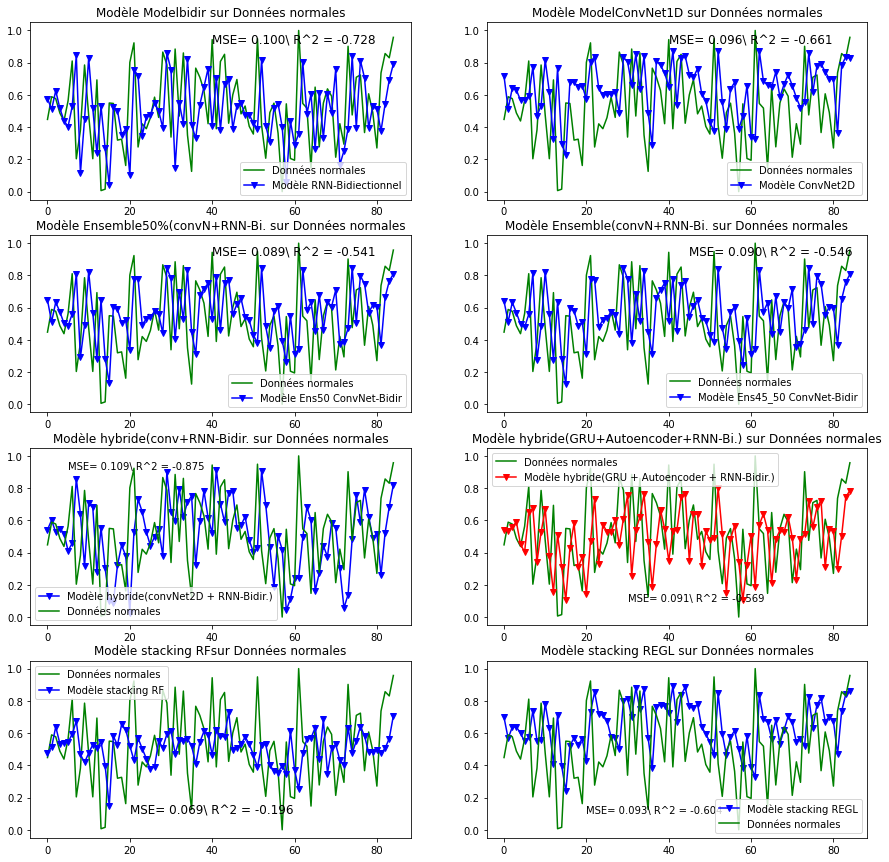

In [18]:

testDeSecuriteModele(x_trainNormale,'normales')

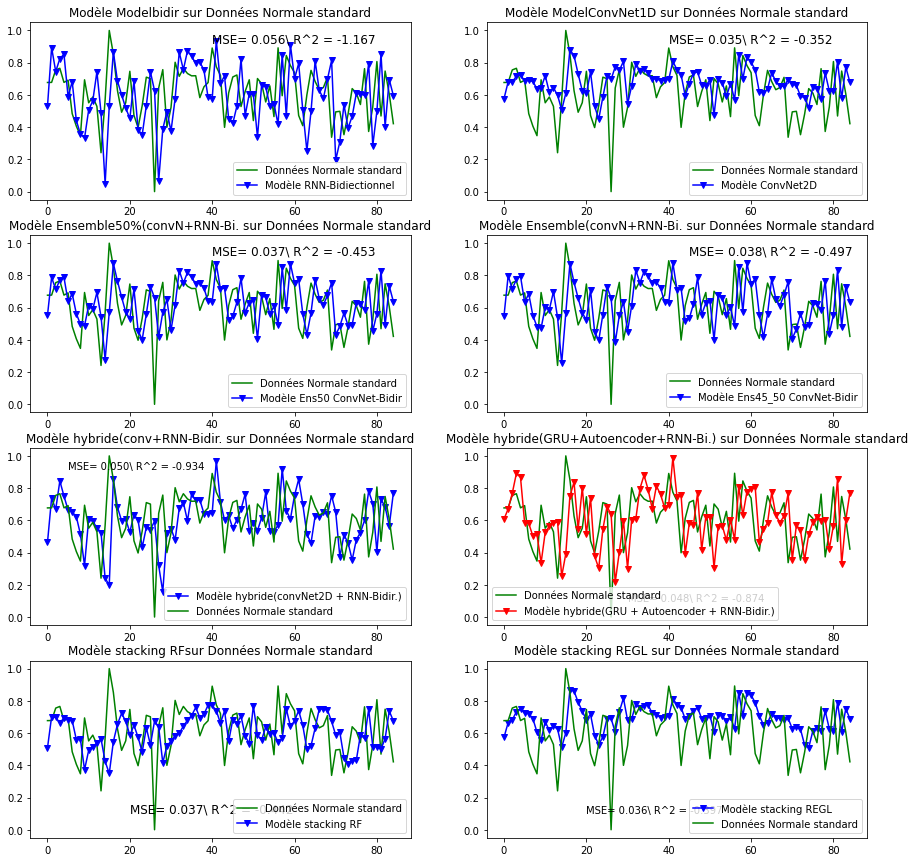

In [19]:
testDeSecuriteModele(x_train_normale_standart,'Normale standard')

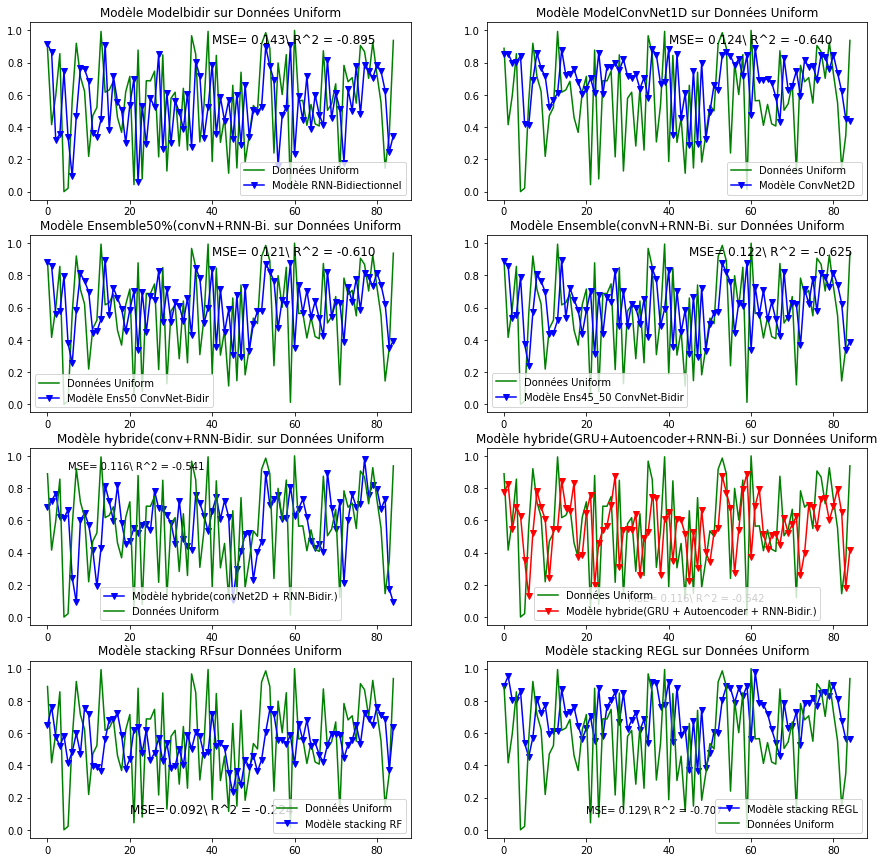

In [20]:
testDeSecuriteModele(x_trainUniform,'Uniform')

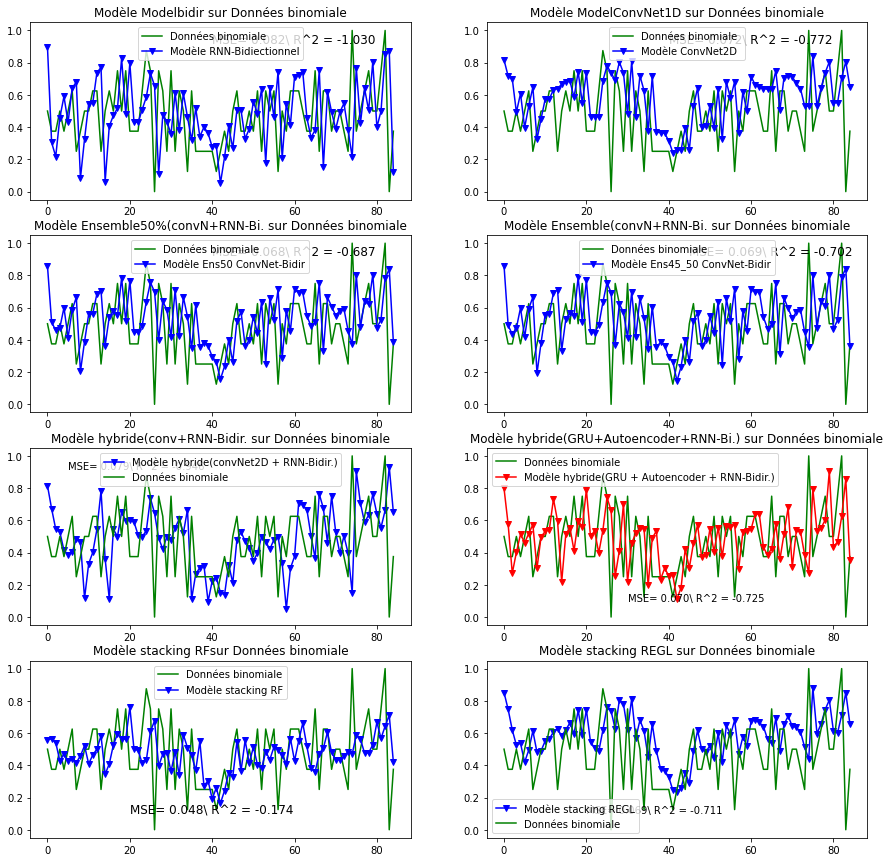

In [21]:
testDeSecuriteModele(x_train_binomiale,'binomiale')

In [ ]:
# VI -: Analyse des résidus de chaque modèle et differentes approches

In [ ]:
# VI -1: Preparation des données

In [ ]:
x_train , y_train= normalisationPreparationDonnee(x_trainning,lags=5)

In [22]:
# VI -2 : Calcul des résidus de chaque modèle


Residusmodelbidir=y_train.reshape(-1,1)-modelbidir.predict(x_train) 

ResidusmodelConvNet1D=y_train.reshape(-1,1)-modelConvNet1D.predict(x_train) 

ResidusmodelEns50=y_train.reshape(-1,1)-0.5*(modelConvNet1D.predict(x_train)+modelbidir.predict(x_train))
ResidusmodelEns45_55=y_train.reshape(-1,1)-(0.45*modelConvNet1D.predict(x_train) + 0.55*modelbidir.predict(x_train))
Residusmodelhybride=y_train.reshape(-1,1)-model.predict(x_train)
ResidusmodelConvNet1DBidirectOP=y_train.reshape(-1,1)-modelConvNet1DBidirectOP.predict(x_train)
Residusstacking_reg_RF=y_train-stacking_reg_RF.predict(x_train)
Residusstacking_reg_REGL=y_train-stacking_reg_REGL.predict(x_train)

In [ ]:
# VI -3 : Graphiques des résidus de chaque modèle

C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

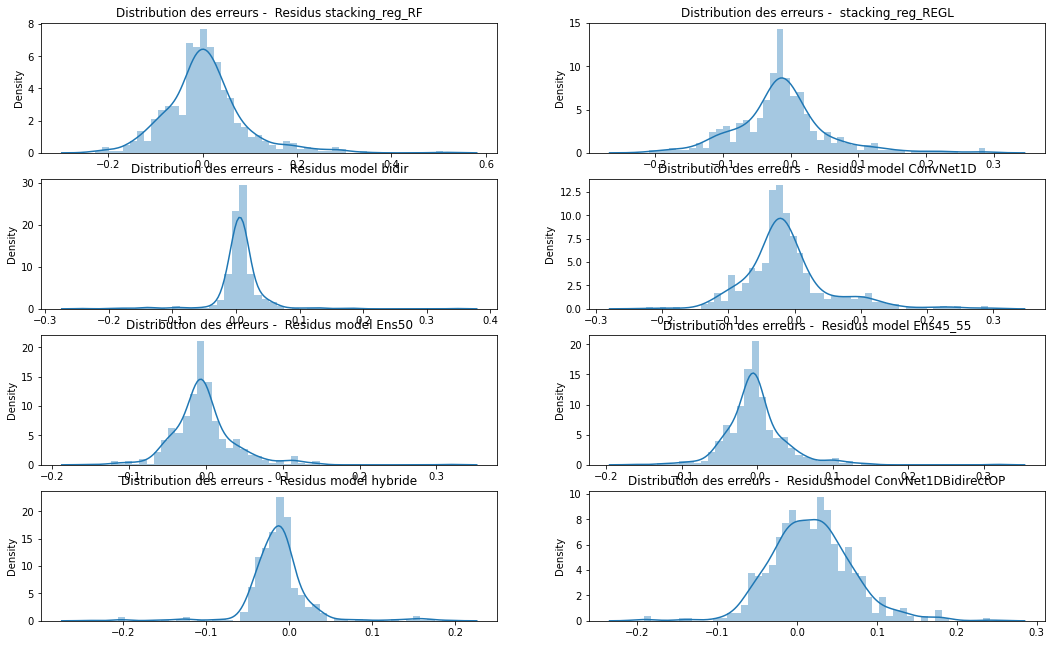

In [23]:
plt.figure(figsize=(18,11)) 
plt.subplot(4,2,1)    
sns.distplot(Residusstacking_reg_RF,bins=50,kde=True)
plt.title('Distribution des erreurs -  Residus stacking_reg_RF')
plt.subplot(4,2,2) 
sns.distplot(Residusstacking_reg_REGL,bins=50,kde=True)
plt.title('Distribution des erreurs -  stacking_reg_REGL')
plt.subplot(4,2,3) 
sns.distplot(Residusmodelbidir,bins=50,kde=True)
plt.title('Distribution des erreurs -  Residus model bidir')
plt.subplot(4,2,4) 
sns.distplot(ResidusmodelConvNet1D,bins=50,kde=True)
plt.title('Distribution des erreurs -  Residus model ConvNet1D')
plt.subplot(4,2,5) 
sns.distplot(ResidusmodelEns50,bins=50,kde=True)
plt.title('Distribution des erreurs -  Residus model Ens50')
plt.subplot(4,2,6) 
sns.distplot(ResidusmodelEns45_55,bins=50,kde=True)
plt.title('Distribution des erreurs -  Residus model Ens45_55')
plt.subplot(4,2,7) 
sns.distplot(Residusmodelhybride,bins=50,kde=True)
plt.title('Distribution des erreurs -  Residus model hybride')
plt.subplot(4,2,8) 
sns.distplot(ResidusmodelConvNet1DBidirectOP,bins=50,kde=True)
plt.title('Distribution des erreurs -  Residusmodel ConvNet1DBidirectOP')
plt.show()


In [24]:
# VII -:Detection des anomalies

In [25]:
# VII -1:Graphique de Distribution des erreurs de prédiction Modèle HYBRIDE ET STACKING

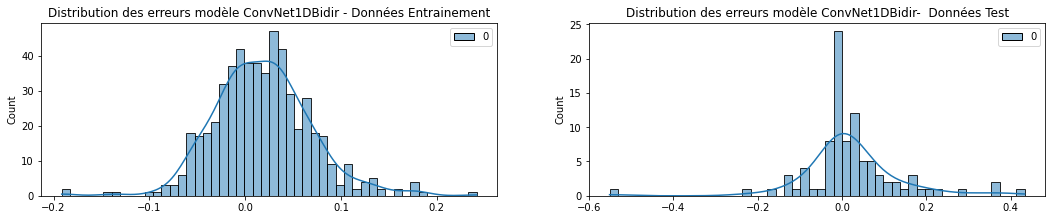

In [26]:
# Graphique de Distribution des erreurs de prédiction Modèle HYBRIDE 

ResidusmodelConvNet1DBidirectOP=y_train.reshape(-1,1)-modelConvNet1DBidirectOP.predict(x_train)

erreursTrain=y_train.reshape(-1,1)-modelConvNet1DBidirectOP.predict(x_train)
erreursTest=y_test.reshape(-1,1)-modelConvNet1DBidirectOP.predict(x_test)

plt.figure(figsize=(18,7)) 
plt.subplot(2,2,1)
sns.histplot(erreursTrain,bins=50,kde=True)
plt.title('Distribution des erreurs modèle ConvNet1DBidir - Données Entrainement')
plt.subplot(2,2,2)
sns.histplot(erreursTest,bins=50,kde=True)
plt.title('Distribution des erreurs modèle ConvNet1DBidir-  Données Test')
plt.show()

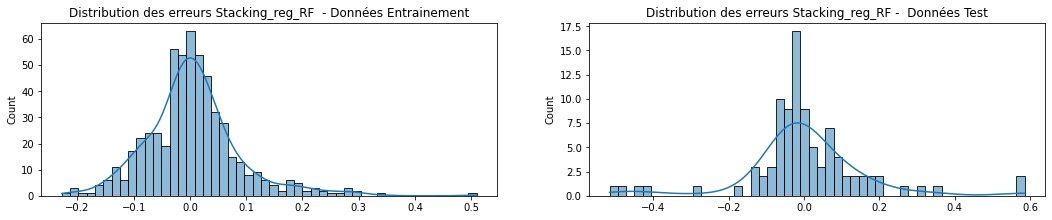

In [27]:
# Graphique de Distribution des erreurs de prédiction Modèle STACKING par Forets aléatoires

erreursTrainStacking_reg_RF=y_train-stacking_reg_RF.predict(x_train)
erreursTestStacking_reg_RF=y_test-stacking_reg_RF.predict(x_test)

plt.figure(figsize=(18,7)) 
plt.subplot(2,2,1)
sns.histplot(erreursTrainStacking_reg_RF,bins=50,kde=True)
plt.title('Distribution des erreurs Stacking_reg_RF  - Données Entrainement')
plt.subplot(2,2,2)
sns.histplot(erreursTestStacking_reg_RF,bins=50,kde=True)
plt.title('Distribution des erreurs Stacking_reg_RF -  Données Test')
plt.show()

In [28]:
# VII -2:Traitement des anomalies
   
def afficheAnomalie(modele,x_train,y_train,x_test,y_test,THRESHOLD_Inf,THRESHOLD_Sup,nomMODEL):
    
    
    # Calcul des erreurs
    erreurs1=y_train.reshape(-1,1)-modele.predict(x_train)
    erreurs2=y_test.reshape(-1,1)-modele.predict(x_test)
    
    # Traintement données entrainements
    data_score_df_train=np.concatenate((erreurs1,y_train.reshape(-1,1),modele.predict(x_train)),axis=1)
    data_score_df_train=pd.DataFrame(data_score_df_train,columns=['loss','cpu','cpu_predit'])
    data_score_df_train['THRESHOLD_Inf']=THRESHOLD_Inf
    data_score_df_train['THRESHOLD_Sup']=THRESHOLD_Sup
    data_score_df_train.loc[data_score_df_train['loss']<=THRESHOLD_Inf,'anomalie']=True
    data_score_df_train.loc[data_score_df_train['loss']>=THRESHOLD_Sup,'anomalie']=True
    anomalies_train=data_score_df_train[data_score_df_train.anomalie==True]
    
    # Traintement données Test
    data_score_df_test=np.concatenate((erreurs2,y_test.reshape(-1,1),modele.predict(x_test)),axis=1)
    data_score_df_test=pd.DataFrame(data_score_df_test,columns=['loss','cpu','cpu_predit'])
    data_score_df_test['THRESHOLD_Inf']=THRESHOLD_Inf
    data_score_df_test['THRESHOLD_Sup']=THRESHOLD_Sup
    data_score_df_test.loc[data_score_df_test['loss']<=THRESHOLD_Inf,'anomalie']=True
    data_score_df_test.loc[data_score_df_test['loss']>=THRESHOLD_Sup,'anomalie']=True
    anomalies_test=data_score_df_test[data_score_df_test.anomalie==True]
    
    plt.figure(figsize=(18,7))
    plt.subplot(1,2,1)
    plt.plot(range(0,len(data_score_df_train.index)),data_score_df_train.cpu,'blue',label='cpu d''origine')
    plt.plot(range(0,len(data_score_df_train.index)),data_score_df_train.cpu_predit,marker='v',label='prediction CPU(%)')
    sns.scatterplot(anomalies_train.index,anomalies_train.cpu,color=sns.color_palette()[3], s=300,label='anomalie')
    plt.xticks(rotation=25)
    plt.xlabel('Minutes,heures, jour')
    plt.ylabel('% cpu')
    plt.title('{} : Données Entrainement: {}  anomalies detectées au seuil α ϵ ] {} ; {} ['.format(nomMODEL,anomalies_train.shape[0], THRESHOLD_Inf,THRESHOLD_Sup))
    plt.legend(loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(range(0,len(data_score_df_test.index)),data_score_df_test.cpu,'blue',label='cpu d''origine')
    plt.plot(range(0,len(data_score_df_test.index)),data_score_df_test.cpu_predit,marker='v',label='prediction CPU(%)')
    sns.scatterplot(anomalies_test.index,anomalies_test.cpu,color=sns.color_palette()[3], s=300,label='anomalie')
    plt.xticks(rotation=25)
    plt.xlabel('Minutes,heures, jour')
    plt.ylabel('% cpu')
    plt.title('{} : Données Test: {}  anomalies detectées au seuil α ϵ ] {} ; {} ['.format(nomMODEL,anomalies_test.shape[0],THRESHOLD_Inf,THRESHOLD_Sup))
    plt.legend(loc='upper left')
    plt.show()
    
  

In [29]:
# VII -3:Detection d'anomalie au seuil de -0.2 et 0.2 pour le modèle Hybride ConvNet-Birectionnel

THRESHOLD_Inf=-0.2
THRESHOLD_Sup=0.2

C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


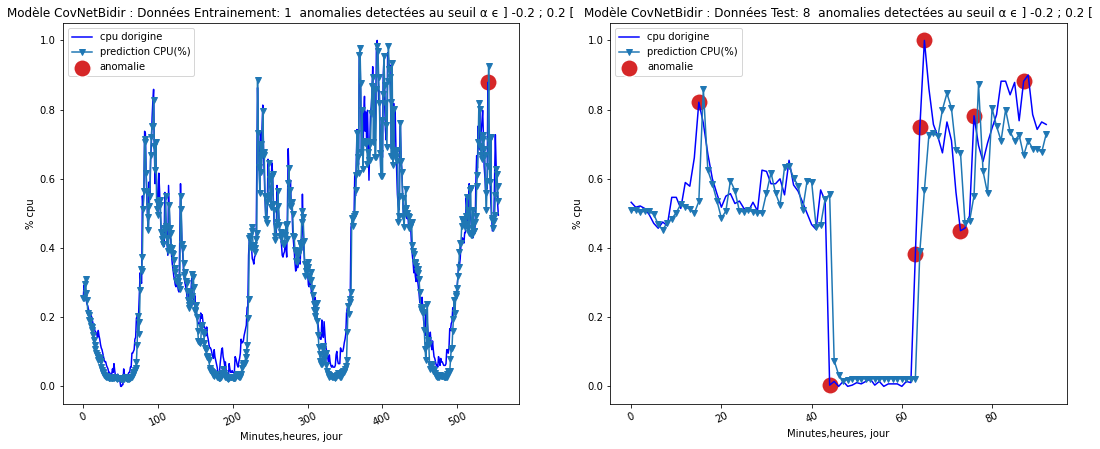

In [30]:
afficheAnomalie(modelConvNet1DBidirectOP,x_train,y_train,x_test,y_test,THRESHOLD_Inf,THRESHOLD_Sup,'Modèle CovNetBidir')

In [ ]:
# VII -4:Detection d'anomalie au seuil de -0.1 et 0.1 pour le modèle Hybride ConvNet-Birectionnel

C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


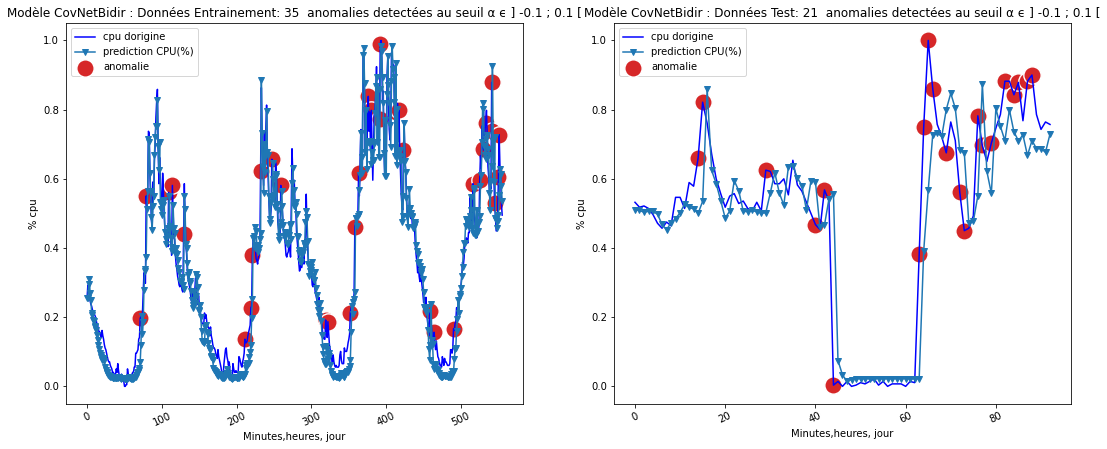

In [31]:
THRESHOLD_Inf=-0.1
THRESHOLD_Sup=0.1
afficheAnomalie(modelConvNet1DBidirectOP,x_train,y_train,x_test,y_test,THRESHOLD_Inf,THRESHOLD_Sup,'Modèle CovNetBidir')

In [32]:
# VII -5:Detection d'anomalie avec le modèle de staking

In [88]:
# Redifinition de la fonction
   
def afficheAnomalieStaking(modele,x_train,y_train,x_test,y_test,THRESHOLD_Inf,THRESHOLD_Sup,nomMODEL):
    
    
    # Calcul des erreurs
    erreurs1=y_train.reshape(-1,1)-modele.predict(x_train).reshape(-1,1)
    erreurs2=y_test.reshape(-1,1)-modele.predict(x_test).reshape(-1,1)
    
    
    # Traintement données entrainements
    data_score_df_train=np.concatenate((erreurs1,y_train.reshape(-1,1),modele.predict(x_train).reshape(-1,1)),axis=1)
    data_score_df_train=pd.DataFrame(data_score_df_train,columns=['loss','cpu','cpu_predit'])
    data_score_df_train['THRESHOLD_Inf']=THRESHOLD_Inf
    data_score_df_train['THRESHOLD_Sup']=THRESHOLD_Sup
    data_score_df_train.loc[data_score_df_train['loss']<=THRESHOLD_Inf,'anomalie']=True
    data_score_df_train.loc[data_score_df_train['loss']>=THRESHOLD_Sup,'anomalie']=True
    anomalies_train=data_score_df_train[data_score_df_train.anomalie==True]
    
    # Traintement données Test
    data_score_df_test=np.concatenate((erreurs2,y_test.reshape(-1,1),modele.predict(x_test).reshape(-1,1)),axis=1)
    data_score_df_test=pd.DataFrame(data_score_df_test,columns=['loss','cpu','cpu_predit'])
    data_score_df_test['THRESHOLD_Inf']=THRESHOLD_Inf
    data_score_df_test['THRESHOLD_Sup']=THRESHOLD_Sup
    data_score_df_test.loc[data_score_df_test['loss']<=THRESHOLD_Inf,'anomalie']=True
    data_score_df_test.loc[data_score_df_test['loss']>=THRESHOLD_Sup,'anomalie']=True
    anomalies_test=data_score_df_test[data_score_df_test.anomalie==True]
    
    plt.figure(figsize=(21,7))
    plt.subplot(1,2,1)
    plt.plot(range(0,len(data_score_df_train.index)),data_score_df_train.cpu,'blue',label='cpu d''origine')
    plt.plot(range(0,len(data_score_df_train.index)),data_score_df_train.cpu_predit,marker='v',label='prediction CPU(%)')
    sns.scatterplot(anomalies_train.index,anomalies_train.cpu,color=sns.color_palette()[3], s=300,label='anomalie')
    plt.xticks(rotation=25)
    plt.xlabel('Minutes,heures, jour')
    plt.ylabel('% cpu')
    plt.title('{} : Données Entrainement: {}  anomalies detectées au seuil α ϵ ] {} ; {} ['.format(nomMODEL,anomalies_train.shape[0], THRESHOLD_Inf,THRESHOLD_Sup))
    plt.legend(loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(range(0,len(data_score_df_test.index)),data_score_df_test.cpu,'blue',label='cpu d''origine')
    plt.plot(range(0,len(data_score_df_test.index)),data_score_df_test.cpu_predit,marker='v',label='prediction CPU(%)')
    sns.scatterplot(anomalies_test.index,anomalies_test.cpu,color=sns.color_palette()[3], s=300,label='anomalie')
    plt.xticks(rotation=25)
    plt.xlabel('Minutes,heures, jour')
    plt.ylabel('% cpu')
    plt.title('{} : Données Test: {}  anomalies detectées au seuil α ϵ ] {} ; {} ['.format(nomMODEL,anomalies_test.shape[0],THRESHOLD_Inf,THRESHOLD_Sup))
    plt.legend(loc='upper left')
    plt.show()
    
  

C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


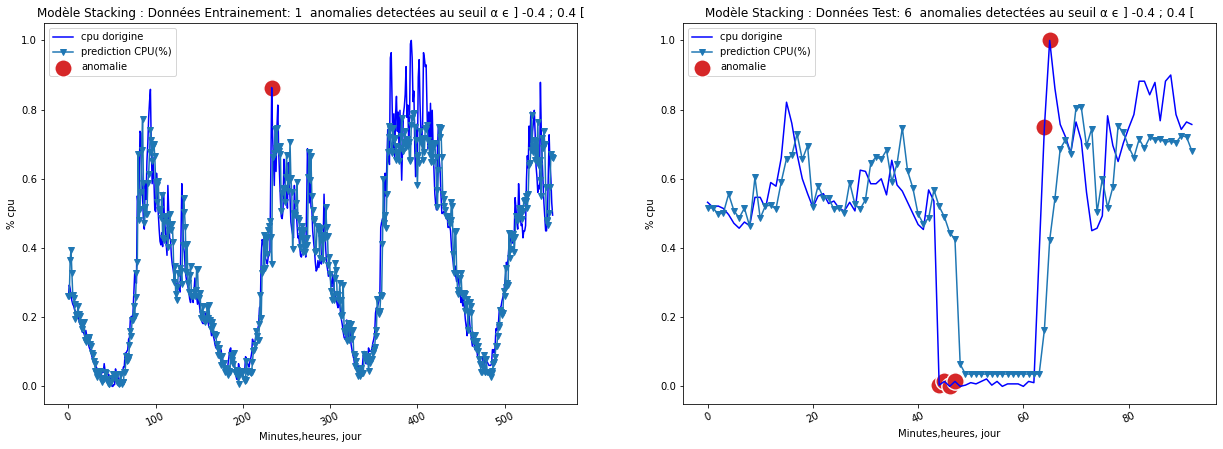

In [89]:
# Detection d'anomalie au seuil de -0.4 et 0.4 pour le modèle stacking par Forets aleatoires
THRESHOLD_Inf=-0.4
THRESHOLD_Sup=0.4
afficheAnomalieStaking(stacking_reg_RF,x_train,y_train,x_test,y_test,THRESHOLD_Inf,THRESHOLD_Sup,'Modèle Stacking')

C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


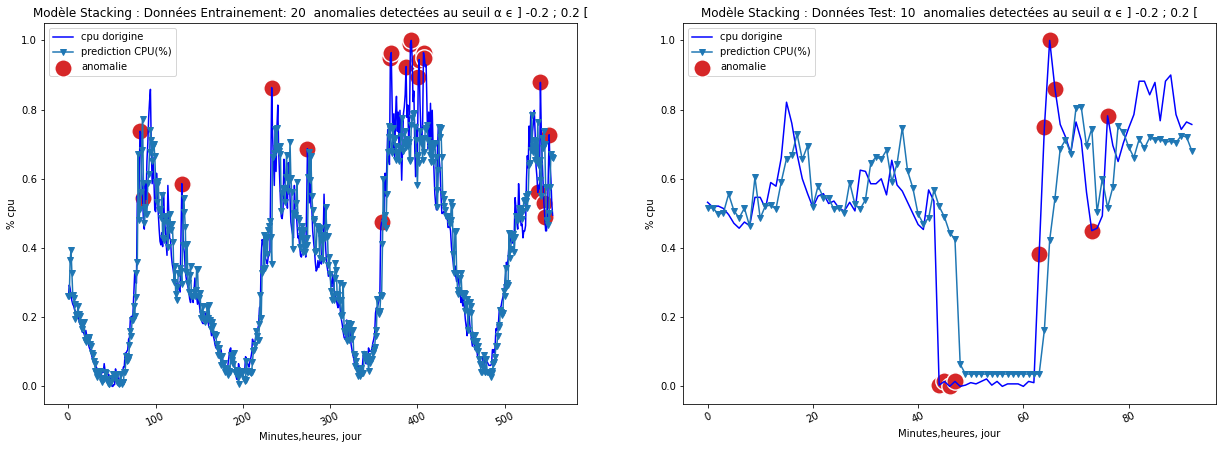

In [90]:
# Detection d'anomalie au seuil de -0.2 et 0.2 pour le modèle stacking par Forets aleatoires
THRESHOLD_Inf=-0.2
THRESHOLD_Sup=0.2
afficheAnomalieStaking(stacking_reg_RF,x_train,y_train,x_test,y_test,THRESHOLD_Inf,THRESHOLD_Sup,'Modèle Stacking')

In [ ]:
# VIII :Test de securité du modèle Hybride ConvNet-Bidirectionnel

In [85]:
# test de securité avec les données normales 
x_trainNormale=np.random.normal(1.26, 0.49, 90)
x_train_normale_standart=np.random.standard_normal(90)

x_trainNor,y_trainNor=normalisationPreparationDonneeSimul(x_trainNormale,5)
x_train_nor_standart,y_train_nor_standart=normalisationPreparationDonneeSimul(x_trainNormale,5)


def afficheAnomalieSecurite(modele,x_train,y_train,x_test,y_test,THRESHOLD_Inf,THRESHOLD_Sup,nomMODEL):
    y_pred_x_train=modele.predict(x_train)
    y_pred_x_test=modele.predict(x_test)
    # Calcul des erreurs
    erreurs1=y_train.reshape(-1,1)-y_pred_x_train
    erreurs2=y_test.reshape(-1,1)-y_pred_x_test
    y_train=y_train.reshape(-1,1)
    y_test=y_test.reshape(-1,1)
    # Traintement données entrainements
    data_score_df_train=np.concatenate((erreurs1,y_train,y_pred_x_train),axis=1)
    data_score_df_train=pd.DataFrame(data_score_df_train,columns=['loss','cpu','cpu_predit'])
    data_score_df_train['THRESHOLD_Inf']=THRESHOLD_Inf
    data_score_df_train['THRESHOLD_Sup']=THRESHOLD_Sup
    data_score_df_train.loc[data_score_df_train['loss']<=THRESHOLD_Inf,'anomalie']=True
    data_score_df_train.loc[data_score_df_train['loss']>=THRESHOLD_Sup,'anomalie']=True
    anomalies_train=data_score_df_train[data_score_df_train.anomalie==True]
    # Traintement données Test
    data_score_df_test=np.concatenate((erreurs2,y_test,y_pred_x_test),axis=1)
    data_score_df_test=pd.DataFrame(data_score_df_test,columns=['loss','cpu','cpu_predit'])
    data_score_df_test['THRESHOLD_Inf']=THRESHOLD_Inf
    data_score_df_test['THRESHOLD_Sup']=THRESHOLD_Sup
    data_score_df_test.loc[data_score_df_test['loss']<=THRESHOLD_Inf,'anomalie']=True
    data_score_df_test.loc[data_score_df_test['loss']>=THRESHOLD_Sup,'anomalie']=True
    anomalies_test=data_score_df_test[data_score_df_test.anomalie==True]
    
    plt.figure(figsize=(21,7))
    plt.subplot(1,2,1)
    plt.plot(range(0,len(data_score_df_train.index)),data_score_df_train.cpu,'blue',label='cpu d''origine')
    plt.plot(range(0,len(data_score_df_train.index)),data_score_df_train.cpu_predit,marker='v',label='prediction CPU(%)')
    sns.scatterplot(anomalies_train.index,anomalies_train.cpu,color=sns.color_palette()[3], s=300,label='anomalie')
    plt.xticks(rotation=25)
    plt.xlabel('Minutes,heures, jour')
    plt.ylabel('% cpu')
    plt.title('{} : Données Normale: {}  anomalies detectées au seuil α ϵ ] {} ; {} ['.format(nomMODEL,anomalies_train.shape[0], THRESHOLD_Inf,THRESHOLD_Sup))
    plt.legend(loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(range(0,len(data_score_df_test.index)),data_score_df_test.cpu,'blue',label='cpu d''origine')
    plt.plot(range(0,len(data_score_df_test.index)),data_score_df_test.cpu_predit,marker='v',label='prediction CPU(%)')
    sns.scatterplot(anomalies_test.index,anomalies_test.cpu,color=sns.color_palette()[3], s=300,label='anomalie')
    plt.xticks(rotation=25)
    plt.xlabel('Minutes,heures, jour')
    plt.ylabel('% cpu')
    plt.title('{} : Données Normale Standard(0,1): {}  anomalies detectées au seuil α ϵ ] {} ; {} ['.format(nomMODEL,anomalies_test.shape[0],THRESHOLD_Inf,THRESHOLD_Sup))
    plt.legend(loc='upper left')
    plt.show()
    

In [86]:
# Detection d'anomalie au seuil de -0.2 et 0.2 pour le modèle Hybride ConvNet-Birectionnel
THRESHOLD_Inf=-0.2
THRESHOLD_Sup=0.2

C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


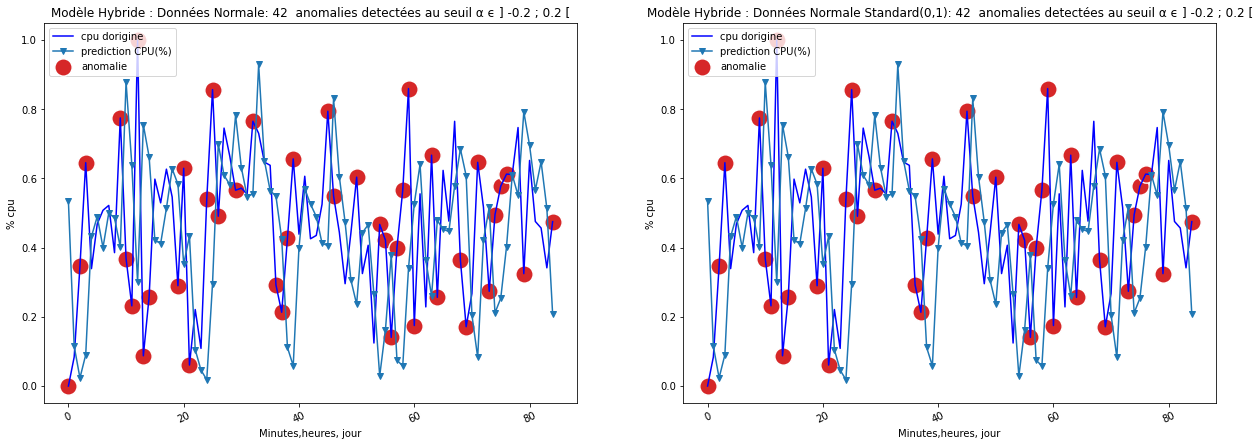

In [87]:
afficheAnomalieSecurite(modelConvNet1DBidirectOP,x_trainNor,y_trainNor,x_train_nor_standart,y_train_nor_standart,THRESHOLD_Inf,THRESHOLD_Sup,'Modèle Hybride')

C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


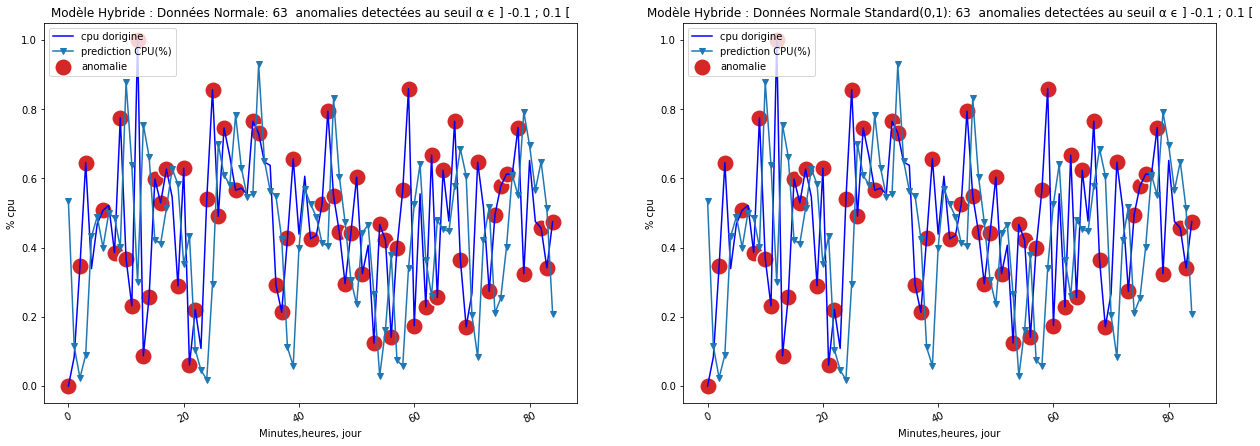

In [91]:
# Detection d'anomalie au seuil de -0.1 et 0.1 pour le modèle Hybride ConvNet-Birectionnel
THRESHOLD_Inf=-0.1
THRESHOLD_Sup=0.1
afficheAnomalieSecurite(modelConvNet1DBidirectOP,x_trainNor,y_trainNor,x_train_nor_standart,y_train_nor_standart,THRESHOLD_Inf,THRESHOLD_Sup,'Modèle Hybride')

In [92]:
# Detection d'anomalie au seuil de -0.06 et 0.06 pour le modèle Hybride ConvNet-Birectionnel

C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\lucgo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


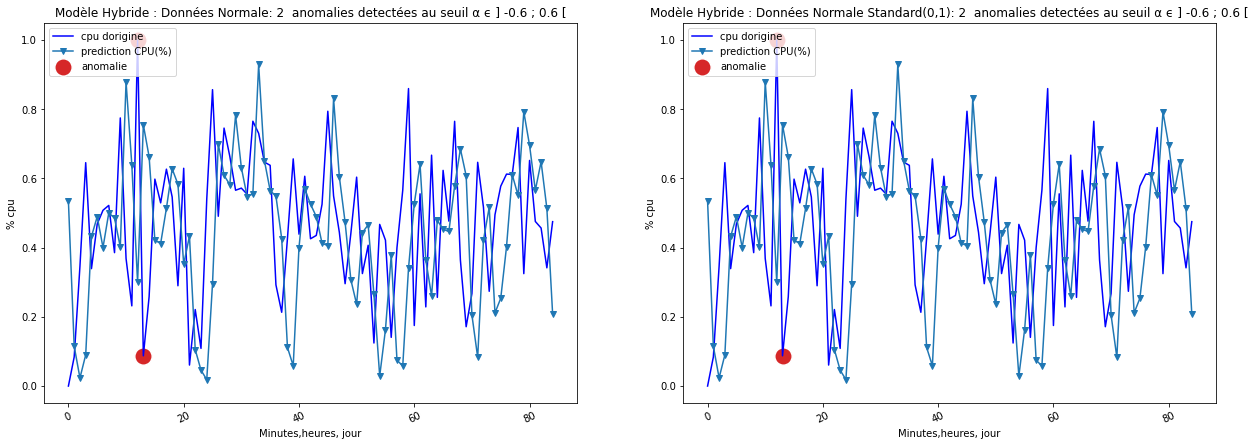

In [94]:
THRESHOLD_Inf=-0.6
THRESHOLD_Sup=0.6
afficheAnomalieSecurite(modelConvNet1DBidirectOP,x_trainNor,y_trainNor,x_train_nor_standart,y_train_nor_standart,THRESHOLD_Inf,THRESHOLD_Sup,'Modèle Hybride')